In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

%matplotlib inline

In [2]:
x_train = pd.read_csv('/home/rashmi/Dataset/pre-processed-mfcc/s2e/audio_train.csv')
x_test = pd.read_csv('/home/rashmi/Dataset/pre-processed-mfcc/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(1704, 23)


In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(1704, 23) (426, 23)
{2: 505, 1: 351, 5: 303, 3: 237, 4: 159, 0: 149}


In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)
svc_classifier = LinearSVC()
mnb_classifier = MultinomialNB()
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

Test Set Accuracy =  0.636
Test Set F-score =  0.656
Test Set Precision =  0.673
Test Set Recall =  0.651
Confusion matrix, without normalization
[[ 9  1 10  0  0  1]
 [ 7 37 38  0  0  9]
 [ 1 24 80  1  1 14]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 10 37  0  0 33]]


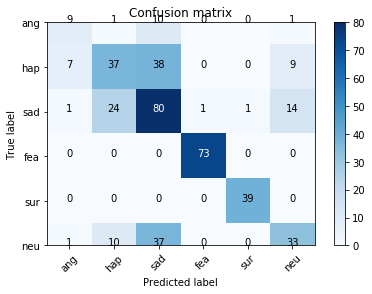

In [8]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('xgb', xgb_classifier), ('mnb', mnb_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

with open('pred_probas/ensemble_mfcc1.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.631
Test Set F-score =  0.650
Test Set Precision =  0.646
Test Set Recall =  0.660
Confusion matrix, without normalization
[[11  3  6  0  0  1]
 [ 7 36 32  1  1 14]
 [ 2 22 78  1  2 16]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 2 15 30  0  2 32]]


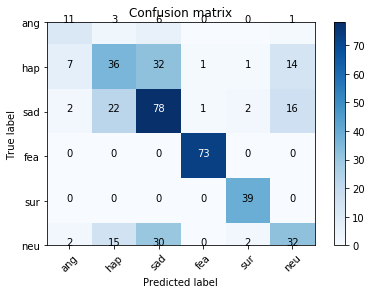

In [7]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('xgb', xgb_classifier), ('mlp', mlp_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

Test Set Accuracy =  0.627
Test Set F-score =  0.651
Test Set Precision =  0.657
Test Set Recall =  0.651
Confusion matrix, without normalization
[[10  2  8  0  0  1]
 [ 8 35 35  0  1 12]
 [ 1 26 76  1  1 16]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 11 35  0  0 34]]


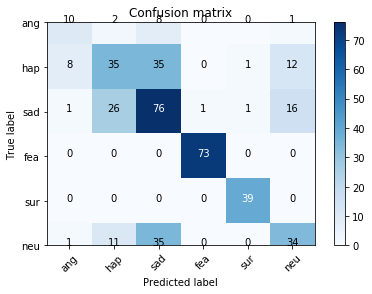

In [8]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('xgb', xgb_classifier), ('lr', lr_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

Test Set Accuracy =  0.613
Test Set F-score =  0.615
Test Set Precision =  0.641
Test Set Recall =  0.619
Confusion matrix, without normalization
[[ 8  3  9  0  0  1]
 [ 4 33 41  1  2 10]
 [ 1 17 89  0  2 12]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 16 43  0  2 19]]


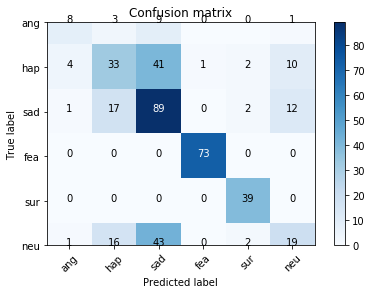

In [9]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('mnb', mnb_classifier), ('mlp', mlp_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

Test Set Accuracy =  0.594
Test Set F-score =  0.602
Test Set Precision =  0.643
Test Set Recall =  0.595
Confusion matrix, without normalization
[[ 8  3  9  0  0  1]
 [ 7 28 47  0  0  9]
 [ 0 22 89  1  0  9]
 [ 0  0  0 73  0  0]
 [ 0  2  2  0 35  0]
 [ 1 10 49  0  1 20]]


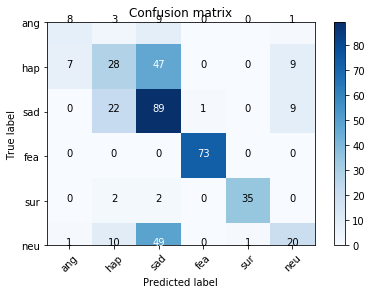

In [10]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('lr', lr_classifier), ('mnb', mnb_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

Test Set Accuracy =  0.629
Test Set F-score =  0.641
Test Set Precision =  0.650
Test Set Recall =  0.648
Confusion matrix, without normalization
[[10  2  8  0  0  1]
 [ 5 34 33  3  2 14]
 [ 2 20 85  1  1 12]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 14 37  0  2 27]]


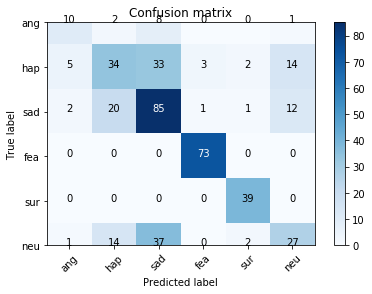

In [11]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('mlp', mlp_classifier), ('lr', lr_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

Test Set Accuracy =  0.629
Test Set F-score =  0.644
Test Set Precision =  0.654
Test Set Recall =  0.650
Confusion matrix, without normalization
[[10  1  9  0  0  1]
 [ 4 34 41  0  1 11]
 [ 4 18 82  1  2 14]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 2 12 35  0  2 30]]


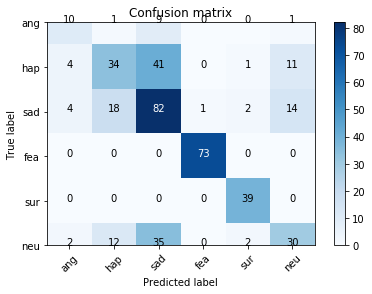

In [12]:
eclf1 = VotingClassifier(estimators=[('xgb', xgb_classifier), ('mnb', mnb_classifier), ('mlp', mlp_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

Test Set Accuracy =  0.631
Test Set F-score =  0.651
Test Set Precision =  0.673
Test Set Recall =  0.645
Confusion matrix, without normalization
[[ 9  1 10  0  0  1]
 [ 7 33 41  0  0 10]
 [ 0 24 83  1  1 12]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 10 38  0  0 32]]


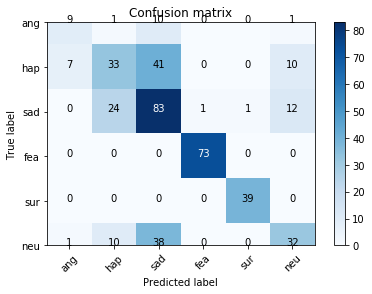

In [13]:
eclf1 = VotingClassifier(estimators=[('xgb', xgb_classifier), ('mnb', mnb_classifier), ('lr', lr_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

Test Set Accuracy =  0.634
Test Set F-score =  0.654
Test Set Precision =  0.654
Test Set Recall =  0.663
Confusion matrix, without normalization
[[11  1  8  0  0  1]
 [ 5 36 33  1  1 15]
 [ 4 22 77  1  3 14]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 11 33  1  1 34]]


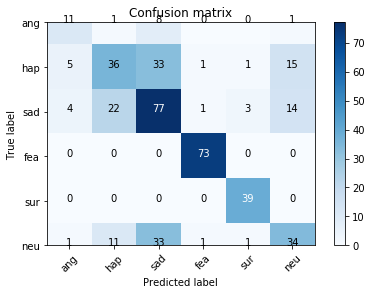

In [14]:
eclf1 = VotingClassifier(estimators=[('mlp', mlp_classifier), ('xgb', xgb_classifier), ('lr', lr_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

Test Set Accuracy =  0.629
Test Set F-score =  0.633
Test Set Precision =  0.636
Test Set Recall =  0.639
Confusion matrix, without normalization
[[ 9  2  9  0  0  1]
 [ 6 33 33  1  2 16]
 [ 3 16 79  2  3 18]
 [ 0  0  0 73  0  0]
 [ 0  0  3  0 36  0]
 [ 2 12 27  0  2 38]]


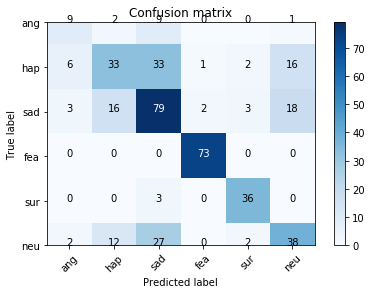

In [15]:
eclf1 = VotingClassifier(estimators=[('lr', lr_classifier), ('mlp', mlp_classifier), ('mnb', mnb_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)